In [3]:
# imports
import io
import base64
import pathlib
import datetime
import random
import numpy as np
import json
import torch
import torch.nn as nn

from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
from model import NCA_model

c:\Users\mrave\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# utility functions

# creates a circle mask given a size, radius and position
def create_circle_mask(size, radius, pos):
    pos = pos * size
    Y, X = np.ogrid[:size, :size]
    dist_from_center = np.sqrt((X - pos[0])**2 + (Y-pos[1])**2)
    mask = dist_from_center >= radius
    return mask

# Loads an image from a specified path and converts to torch.Tensor
def load_image(path, size):
    img = Image.open(path)
    img = img.resize((size, size), Image.Resampling.BILINEAR)
    img = np.float32(img) / 255.0
    img[..., :3] *= img[..., 3:]
    return torch.from_numpy(img).permute(2, 0, 1)[None, ...]

# converts an RGBA image to a RGB image
def to_rgb(img_rgba):
    rgb, a = img_rgba[:, :3, ...], torch.clamp(img_rgba[:, 3:, ...], 0, 1)
    return torch.clamp(1.0 - a + rgb, 0, 1)

def show_image(img):
    img_rgb = to_rgb(img).squeeze().permute(1, 2, 0)
    plt.axis('off')
    plt.imshow(img_rgb)

# Create a starting tensor for training
# Only the active pixels are goin to be in the middle
def make_seed(size, n_channels):
    x = torch.zeros((1, n_channels, size, size), dtype=torch.float32)
    x[:, 3:, size // 2, size // 2] = 1
    return x

In [6]:
# training parameters
img = 'imgs\pup.png'
name = 'pup64'
save_model = True

size = 64
pad = 16
n_channels = 16
n_train_iter = 5000
batch_size = 8
pool_size = 1024
n_damage = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print ('cuda available? ', torch.cuda.is_available())
print ('device: ', device)

eval_freq = 500
eval_iter = 300

log_dir = 'logs'
model_dir = 'models'

cuda available?  False
device:  cpu


img_rgb.shape:  torch.Size([64, 64, 3])


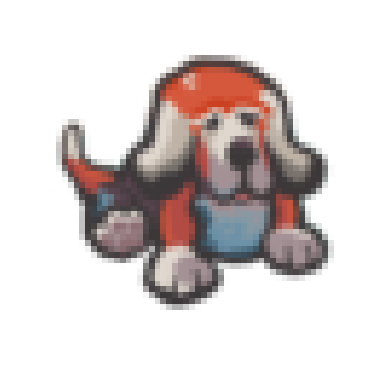

In [18]:
# misc
full_size = size + (2 * pad)
device = torch.device(device)

# create log
log_path = pathlib.Path(log_dir)
log_path.mkdir(parents=True, exist_ok=True)

# target image
loaded_img = load_image(img, size)
target_img_ = nn.functional.pad(loaded_img, (pad, pad, pad, pad), 'constant', 0)
target_img = target_img_.to(device)
target_img = target_img.repeat(batch_size, 1, 1, 1)

show_image(loaded_img)

In [ ]:
# model and optimizer
model = NCA_model(_n_channels=args.n_channels, _device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

# pool init
seed = make_seed(args.size, args.n_channels).to(device)
seed = nn.functional.pad(seed, (p, p, p, p), 'constant', 0)
pool = seed.clone().repeat(args.pool_size, 1, 1, 1)

# training loop
for it in tqdm(range(n_train_iter)):
    batch_ixs = np.random.choice(
        pool_size, batch_size, replace=False
    ).tolist()
    
    # get training batch
    x = pool[batch_ixs]
    
    # damage examples in batch
    if n_damage > 0:
        radius = random.uniform(size*0.1, size*0.4)
        u = random.uniform(0, 1) * size + pad
        v = random.uniform(0, 1) * size + pad
        mask = create_circle_mask(full_size, radius, [u, v])
        x[-n_damage:] *= torch.tensor(mask).to(device)
    
    # forward pass
    for i in range(np.random.randint(64, 96)):
        x = model(x)
    
    loss_batch = ((target_img - x[:, :4, ...]) ** 2).mean(dim=[1, 2, 3])
    loss = loss_batch.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print ('train/loss: ', it, '/', loss)
    
    # find best in batch
    argmax_batch = loss_batch.argmax().item()
    argmax_pool = batch_ixs[argmax_batch]
    remaining_batch = [i for i in range(batch_size) if i != argmax_batch]
    remaining_pool = [i for i in batch_ixs if i != argmax_pool]
    
    pool[argmax_pool] = seed.clone()
    pool[remaining_pool] = x[remaining_batch].detach()
    
    if it % eval_freq == 0:
        x_eval = seed.clone()
        eval_video = torch.empty(1, eval_freq, 3, *x_eval.shape[2:])
        for it_eval in range(eval_iter):
            x_eval = model(x_eval)
            x_eval_out = to_rgb(x_eval[:, :4].detach().cpu())
            eval_video[0, it_eval] = x_eval_out
                    
# save model
if save_model:
    model_path = pathlib.Path(model_dir)
    model_path.mkdir(parents=True, exist_ok=True)
    if name == None:
        ts = str(datetime.datetime.now()).replace(' ', '_').replace(':', '-').replace('.', '-')
        name = 'model_' + ts
    torch.save(model, model_dir + '\\' + name + '.pt')
    
    # save model parameters
    dict = {
        "img": img,
        "batch_size": batch_size,
        "device": device,
        "eval_freq": eval_freq,
        "eval_iter": eval_iter,
        "n_train_iter": n_train_iter,
        "n_channels": n_channels,
        "log_dir": log_dir,
        "pad": pad,
        "pool_size": pool_size,
        "size": size,
        "save_model": save_model,
        "model_dir": model_dir,
        "name": name,
        "damage": n_damage
    }
    json_object = json.dumps(dict, indent=4)
    with open(model_dir + '\\' + name + '_params.json', 'w') as outfile:
        outfile.write(json_object)